In [41]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import ast
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Loading in the data sets

In [42]:
credits_df = pd.read_csv('dataset/credits.csv')
titles_df = pd.read_csv('dataset/titles.csv')

## Credits data frame
This data frame shows the actors and directors with their respective movies and shows

In [43]:
credits_df.head()

person_id       id             name                character   role
0       3748  tm84618   Robert De Niro            Travis Bickle  ACTOR
1      14658  tm84618     Jodie Foster            Iris Steensma  ACTOR
2       7064  tm84618    Albert Brooks                      Tom  ACTOR
3       3739  tm84618    Harvey Keitel  Matthew 'Sport' Higgins  ACTOR
4      48933  tm84618  Cybill Shepherd                    Betsy  ACTOR

## Titles data frame
This data frame shows the attributes relating to each movie or show with their corresponding imdb scores

In [44]:
titles_df.head()

id                                title   type  \
0  ts300399  Five Came Back: The Reference Films   SHOW   
1   tm84618                          Taxi Driver  MOVIE   
2  tm154986                          Deliverance  MOVIE   
3  tm127384      Monty Python and the Holy Grail  MOVIE   
4  tm120801                      The Dirty Dozen  MOVIE   

                                         description  release_year  \
0  This collection includes 12 World War II-era p...          1945   
1  A mentally unstable Vietnam War veteran works ...          1976   
2  Intent on seeing the Cahulawassee River before...          1972   
3  King Arthur, accompanied by his squire, recrui...          1975   
4  12 American military prisoners in World War II...          1967   

  age_certification  runtime                                       genres  \
0             TV-MA       51                            ['documentation']   
1                 R      114                           ['drama', 'crime']   
2                 R      109  ['drama', 'action', 'thriller', 'european']   
3                PG       91              ['fantasy', 'action', 'comedy']   
4               NaN      150                            ['war', 'action']   

  production_countries  seasons    imdb_id  imdb_score  imdb_votes  \
0               ['US']      1.0        NaN         NaN         NaN   
1               ['US']      NaN  tt0075314         8.2    808582.0   
2               ['US']      NaN  tt0068473         7.7    107673.0   
3               ['GB']      NaN  tt0071853         8.2    534486.0   
4         ['GB', 'US']      NaN  tt0061578         7.7     72662.0   

   tmdb_popularity  tmdb_score  
0            0.600         NaN  
1           40.965       8.179  
2           10.010       7.300  
3           15.461       7.811  
4           20.398       7.600

## Differences between the two data frames
Here we discover that some movies/shows from the titles data frame do not appear in the credits data frame.
There movies and shows will get automatically removed on merge.

In [45]:
# Remove all duplicates
credits_movie_ids = set(credits_df['id'])
titles_movie_ids = set(titles_df['id'])

# Find movie/shows ids that are in titles but not in credits
media_not_in_credits = titles_df[~titles_df['id'].isin(credits_movie_ids)]
print(len(media_not_in_credits))

361


## Group all actors and directors with their respective media
This will give us a list of all actors and directors for each movie and show

In [46]:
# Group by movie id and aggregate the data into lists
grouped_credits_df = credits_df.groupby('id').agg({
    'person_id': lambda x: list(x),
    'name': lambda x: list(x),
    'character': lambda x: list(x),
    'role': lambda x: list(x)
}).reset_index()

# Separate actors and directors into new columns
grouped_credits_df['actor'] = [[name for name, role in zip(names, roles) if role == 'ACTOR'] for names, roles in zip(grouped_credits_df['name'], grouped_credits_df['role'])]
grouped_credits_df['director'] = [[name for name, role in zip(names, roles) if role == 'DIRECTOR'] for names, roles in zip(grouped_credits_df['name'], grouped_credits_df['role'])]

# Create new columns for actor_ids and director_ids
grouped_credits_df['actor_ids'] = [[pid for pid, role in zip(pids, roles) if role == 'ACTOR'] for pids, roles in zip(grouped_credits_df['person_id'], grouped_credits_df['role'])]
grouped_credits_df['director_ids'] = [[pid for pid, role in zip(pids, roles) if role == 'DIRECTOR'] for pids, roles in zip(grouped_credits_df['person_id'], grouped_credits_df['role'])]

# Drop unnecessary columns
grouped_credits_df.drop(['name', 'role', 'person_id'], axis=1, inplace=True)
grouped_credits_df

id                                          character  \
0     tm1000037  [Maxi, Karl, Alex, Ante, Jitka, Pankraz, Didie...   
1     tm1000147  [David Carmichael, Jane, Marlon Veidt, Joseph ...   
2      tm100015  [Gordon Jennings, John Rahway, Jack Welles, Ja...   
3     tm1000166  [Himself, Himself, Herself, Herself, Himself, ...   
4     tm1000185  [Monika/Klaudia, Enzo, Ojciec Moniki, Ilona, J...   
...         ...                                                ...   
5484    ts97584                              [Himself - Host, nan]   
5485     ts9794                                      [Self - Host]   
5486    ts98252  [Skipper (voice), Rico the Penguin (voice), Me...   
5487    ts98316                                         [Narrator]   
5488      ts987  [Danger Mouse / Narrator (voice), Penfold (voi...   

                                                  actor  \
0     [Luna Wedler, Jannis Niewöhner, Milan Peschel,...   
1     [Guy Pearce, Matilda Anna Ingrid Lutz, Travis ...   
2     [Idris Elba, Paul Walker, Matt Dillon, Michael...   
3     [Glenn Fredly, Marcello Tahitoe, Andien Aisyah...   
4     [Adrianna Chlebicka, Mateusz Banasiuk, Mirosła...   
...                                                 ...   
5484                                  [Sebastian Perry]   
5485                                   [Jerry Seinfeld]   
5486  [Tom McGrath, John DiMaggio, David Schwimmer, ...   
5487                                        [John Hurt]   
5488  [David Jason, Terry Scott, Edward Kelsey, Bria...   

                   director  \
0     [Christian Schwochow]   
1            [Andrew Baird]   
2         [John Luessenhop]   
3            [Saron Sakina]   
4            [Filip Zylber]   
...                     ...   
5484     [William Mitchell]   
5485                     []   
5486                     []   
5487                     []   
5488                     []   

                                              actor_ids director_ids  
0     [251702, 41192, 589580, 191901, 237433, 76618,...     [142171]  
1     [5080, 159223, 35608, 595294, 9714, 60547, 772...     [954232]  
2     [1675, 2673, 13138, 5130, 13145, 13137, 10712,...      [13150]  
3     [248002, 1793972, 930514, 1794044, 1793676, 24...    [1793832]  
4     [1562688, 299215, 106368, 254540, 97525, 20121...     [446979]  
...                                                 ...          ...  
5484                                          [1323916]    [1324096]  
5485                                            [32954]           []  
5486  [9240, 1950, 9232, 22676, 5664, 8709, 916, 630...           []  
5487                                             [4824]           []  
5488                       [43162, 99172, 18355, 99173]           []  

[5489 rows x 6 columns]

## Merge the two data frames into one data frame

In [47]:
# Merge titles dataframe with grouped credits dataframe
media_df = pd.merge(titles_df, grouped_credits_df, left_on = "id", right_on = "id")

media_df

id                            title   type  \
0       tm84618                      Taxi Driver  MOVIE   
1      tm154986                      Deliverance  MOVIE   
2      tm127384  Monty Python and the Holy Grail  MOVIE   
3      tm120801                  The Dirty Dozen  MOVIE   
4       ts22164     Monty Python's Flying Circus   SHOW   
...         ...                              ...    ...   
5484  tm1216735                  Sun of the Soil  MOVIE   
5485   tm985215             Princess 'Daya'Reese  MOVIE   
5486  tm1097142                         My Bride  MOVIE   
5487  tm1014599                        Fine Wine  MOVIE   
5488  tm1059008                          Lokillo  MOVIE   

                                            description  release_year  \
0     A mentally unstable Vietnam War veteran works ...          1976   
1     Intent on seeing the Cahulawassee River before...          1972   
2     King Arthur, accompanied by his squire, recrui...          1975   
3     12 American military prisoners in World War II...          1967   
4     A British sketch comedy series with the shows ...          1969   
...                                                 ...           ...   
5484  In 14th-century Mali, an ambitious young royal...          2022   
5485  Reese is a con artist from Manila who dreams o...          2021   
5486  The story follows a young man and woman who go...          2021   
5487  A beautiful love story that can happen between...          2021   
5488  A controversial TV host and comedian who has b...          2021   

     age_certification  runtime                                       genres  \
0                    R      114                           ['drama', 'crime']   
1                    R      109  ['drama', 'action', 'thriller', 'european']   
2                   PG       91              ['fantasy', 'action', 'comedy']   
3                  NaN      150                            ['war', 'action']   
4                TV-14       30                       ['comedy', 'european']   
...                ...      ...                                          ...   
5484               NaN       26                                           []   
5485               NaN      115                        ['comedy', 'romance']   
5486               NaN       93               ['romance', 'comedy', 'drama']   
5487               NaN      100                         ['romance', 'drama']   
5488               NaN       90                                   ['comedy']   

     production_countries  seasons     imdb_id  imdb_score  imdb_votes  \
0                  ['US']      NaN   tt0075314         8.2    808582.0   
1                  ['US']      NaN   tt0068473         7.7    107673.0   
2                  ['GB']      NaN   tt0071853         8.2    534486.0   
3            ['GB', 'US']      NaN   tt0061578         7.7     72662.0   
4                  ['GB']      4.0   tt0063929         8.8     73424.0   
...                   ...      ...         ...         ...         ...   
5484                   []      NaN         NaN         NaN         NaN   
5485               ['PH']      NaN  tt13399802         7.1        50.0   
5486               ['EG']      NaN  tt14216488         5.0       327.0   
5487               ['NG']      NaN  tt13857480         6.8        45.0   
5488               ['CO']      NaN  tt14585902         3.8        68.0   

      tmdb_popularity  tmdb_score  \
0              40.965       8.179   
1              10.010       7.300   
2              15.461       7.811   
3              20.398       7.600   
4              17.617       8.306   
...               ...         ...   
5484            1.179       7.000   
5485            1.383         NaN   
5486            2.545       5.300   
5487            1.466         NaN   
5488           26.005       6.300   

                                              character  \
0     [Travis Bickle, Iris Steensma, Tom, Matthew 'S...   
1     [Ed Gent

# A look at the data structure

## Summary of all numerical attributes

In [48]:
media_df.describe()

release_year      runtime      seasons   imdb_score    imdb_votes  \
count   5489.000000  5489.000000  1840.000000  5063.000000  5.049000e+03   
mean    2016.346147    78.995263     2.227717     6.503279  2.464454e+04   
std        7.010669    38.574447     2.807934     1.155218  9.822354e+04   
min     1954.000000     0.000000     1.000000     1.500000  5.000000e+00   
25%     2016.000000    46.000000     1.000000     5.800000  6.080000e+02   
50%     2018.000000    86.000000     1.000000     6.600000  2.523000e+03   
75%     2020.000000   105.000000     2.000000     7.300000  1.055600e+04   
max     2022.000000   240.000000    42.000000     9.500000  2.294231e+06   

       tmdb_popularity   tmdb_score  
count      5487.000000  5317.000000  
mean         23.417779     6.804581  
std          83.486521     1.138524  
min           0.600000     1.000000  
25%           2.902500     6.100000  
50%           7.095000     6.900000  
75%          17.262500     7.500000  
max        2274.044000    10.000000

## Description of the data so far

In [49]:
media_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5489 entries, 0 to 5488
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    5489 non-null   object 
 1   title                 5488 non-null   object 
 2   type                  5489 non-null   object 
 3   description           5481 non-null   object 
 4   release_year          5489 non-null   int64  
 5   age_certification     2990 non-null   object 
 6   runtime               5489 non-null   int64  
 7   genres                5489 non-null   object 
 8   production_countries  5489 non-null   object 
 9   seasons               1840 non-null   float64
 10  imdb_id               5120 non-null   object 
 11  imdb_score            5063 non-null   float64
 12  imdb_votes            5049 non-null   float64
 13  tmdb_popularity       5487 non-null   float64
 14  tmdb_score            5317 non-null   float64
 15  character            

## Ratings count
Here we see how many rows belong to each rating

In [50]:
media_df['imdb_score'].value_counts()

imdb_score
6.5    195
7.1    190
6.7    188
7.4    186
6.3    179
      ... 
1.5      1
9.5      1
9.2      1
1.6      1
1.7      1
Name: count, Length: 78, dtype: int64

# Start EDA

## Histogram

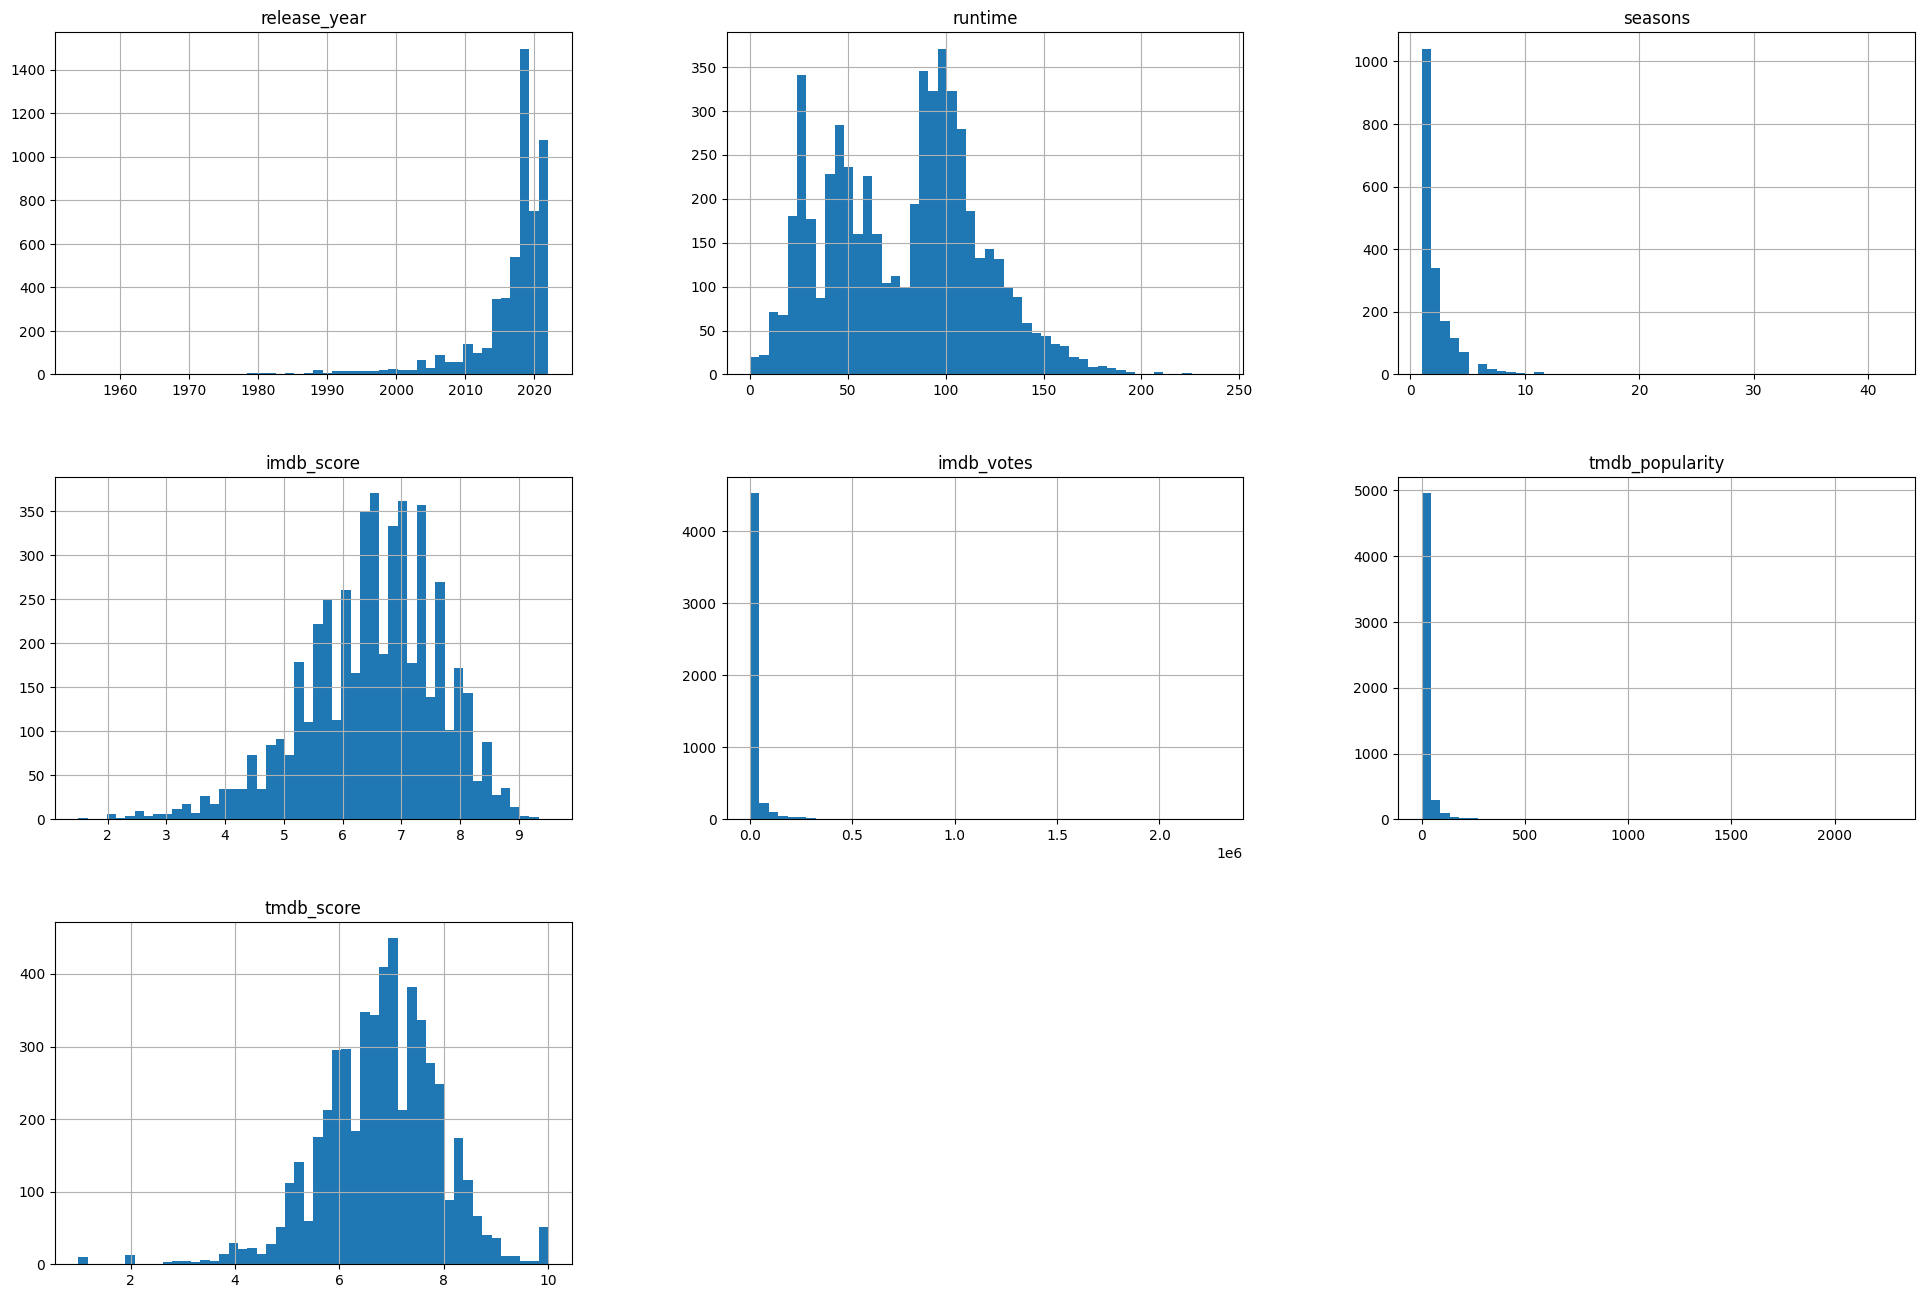

In [51]:
media_df.hist(bins=50, figsize=(24, 16))
plt.show()

## Correlations

### General correlations

release_year   runtime   seasons  imdb_score  imdb_votes  \
release_year         1.000000 -0.177101 -0.535886   -0.130013   -0.208240   
runtime             -0.177101  1.000000 -0.151898   -0.147415    0.134900   
seasons             -0.535886 -0.151898  1.000000    0.104950    0.204067   
imdb_score          -0.130013 -0.147415  0.104950    1.000000    0.197259   
imdb_votes          -0.208240  0.134900  0.204067    0.197259    1.000000   
tmdb_popularity      0.046217 -0.007768  0.166052    0.018180    0.207808   
tmdb_score           0.029133 -0.271951  0.048226    0.587753    0.121751   

                 tmdb_popularity  tmdb_score  
release_year            0.046217    0.029133  
runtime                -0.007768   -0.271951  
seasons                 0.166052    0.048226  
imdb_score              0.018180    0.587753  
imdb_votes              0.207808    0.121751  
tmdb_popularity         1.000000    0.079296  
tmdb_score              0.079296    1.000000

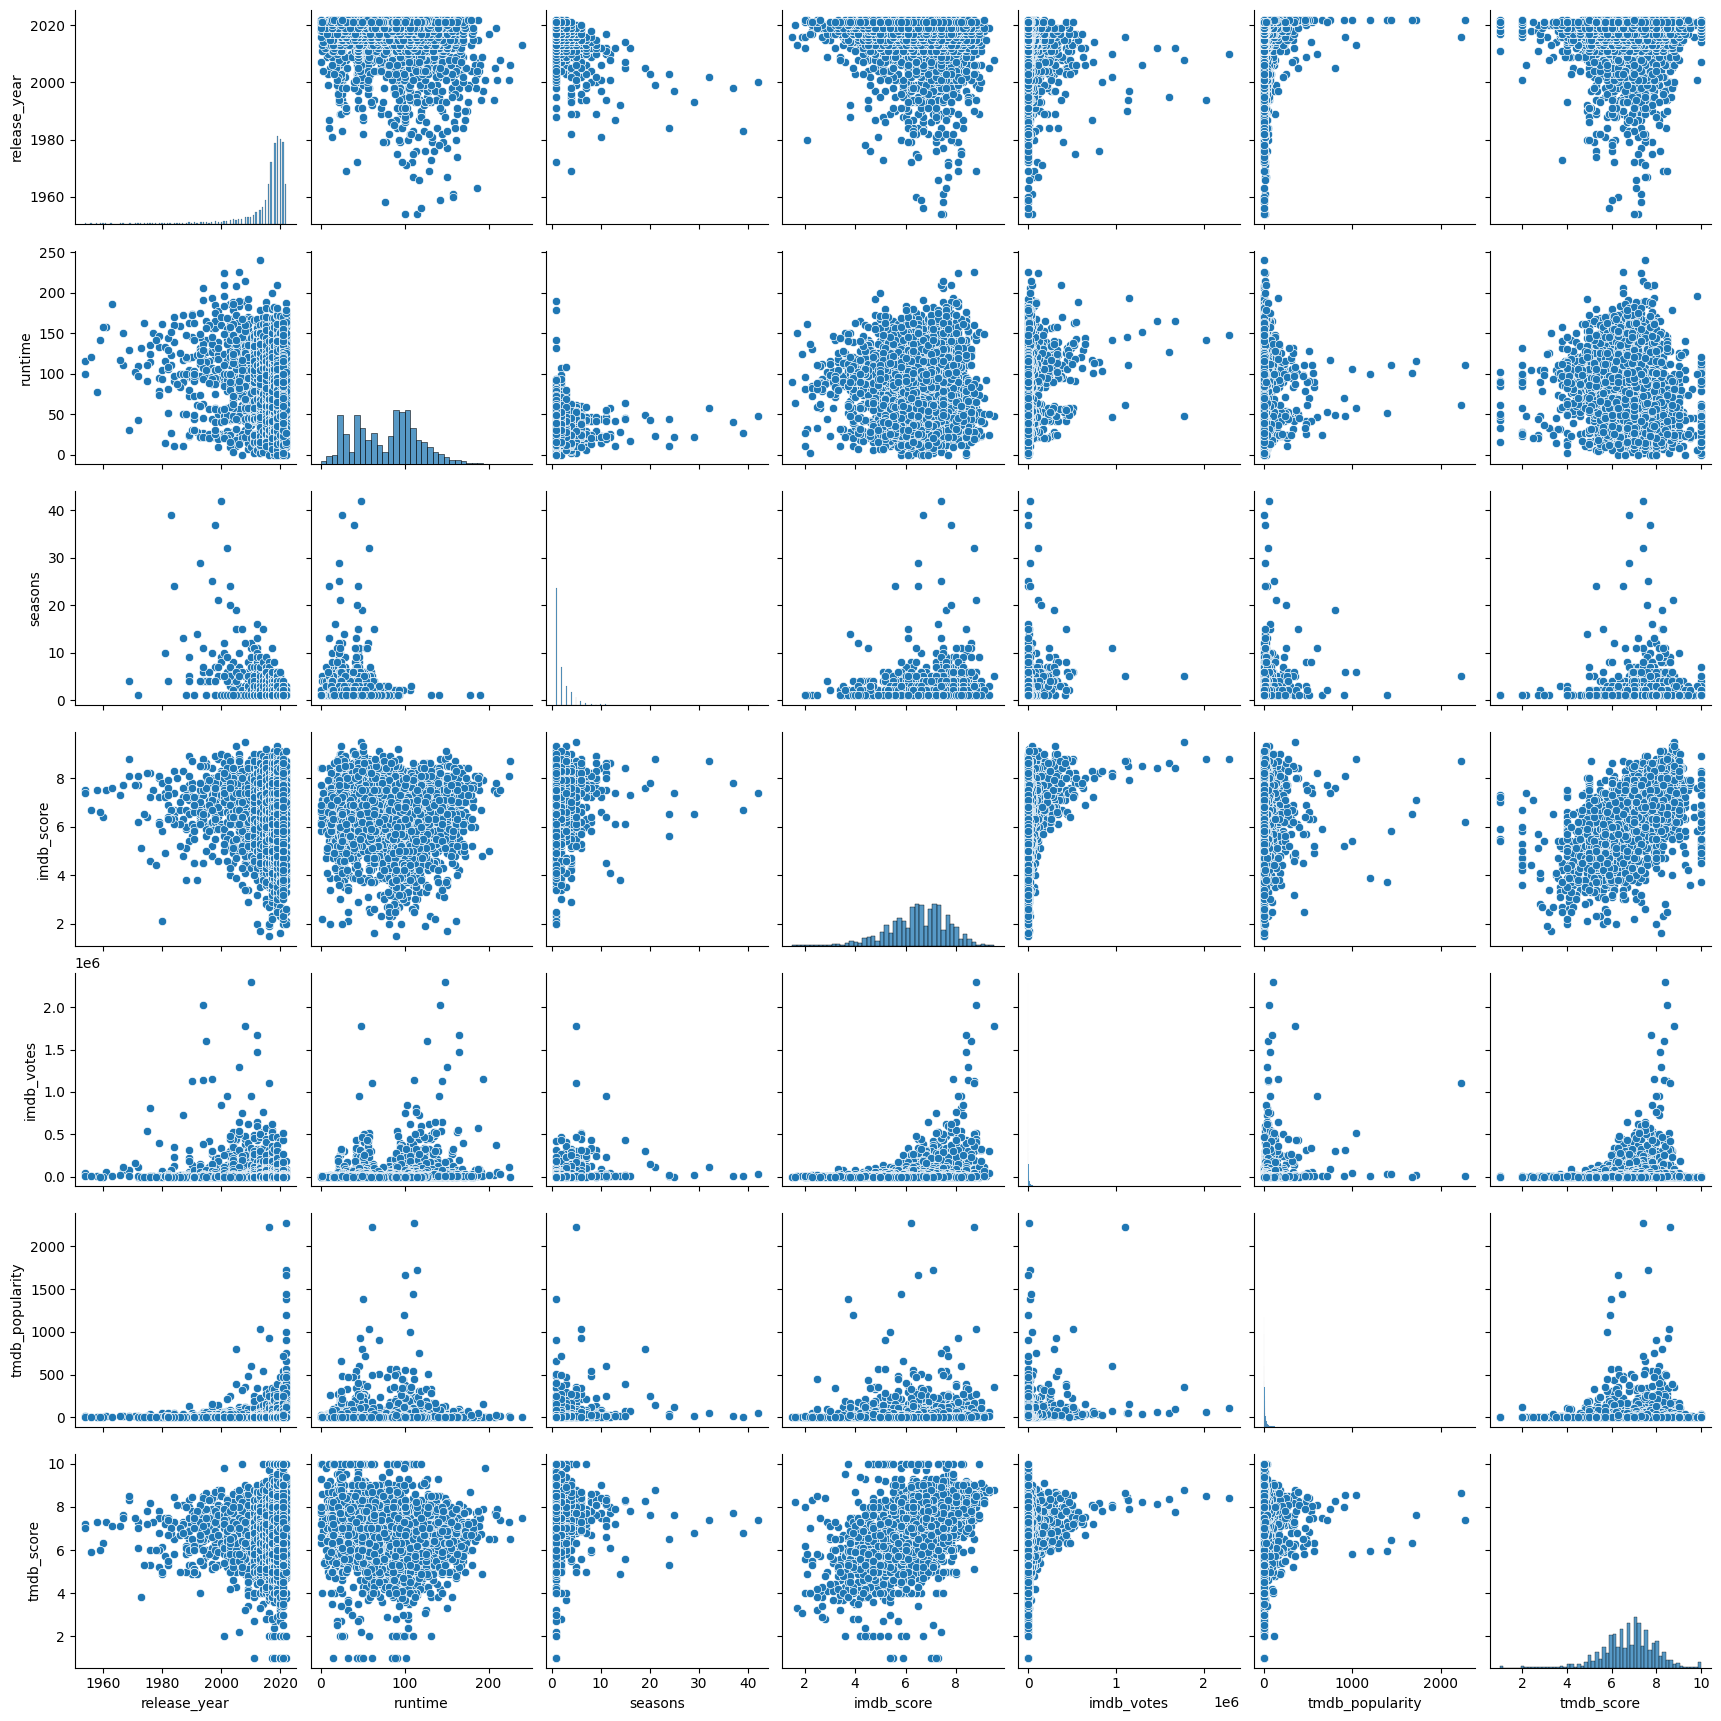

In [52]:
sns.pairplot(media_df)
corr_matrix = media_df.corr(numeric_only=True)
corr_matrix

### Correlations with imdb

In [53]:
corr_matrix['imdb_score'].sort_values(ascending=False)

imdb_score         1.000000
tmdb_score         0.587753
imdb_votes         0.197259
seasons            0.104950
tmdb_popularity    0.018180
release_year      -0.130013
runtime           -0.147415
Name: imdb_score, dtype: float64

## Line graph showing correlation of imdb_score vs tmdb_score

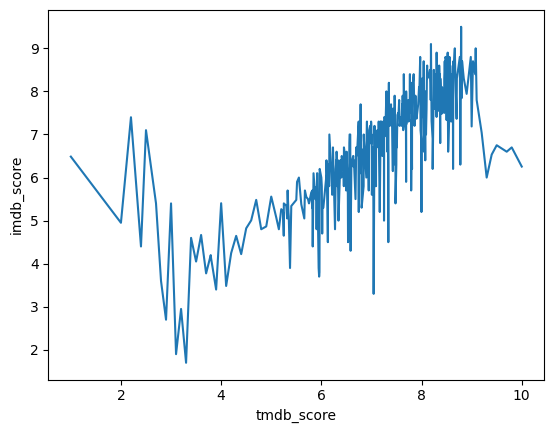

In [54]:
g = sns.lineplot(x="tmdb_score", y="imdb_score", data=media_df, errorbar=None)

## Line graph showing the imdb_score vs tmdb_score over time

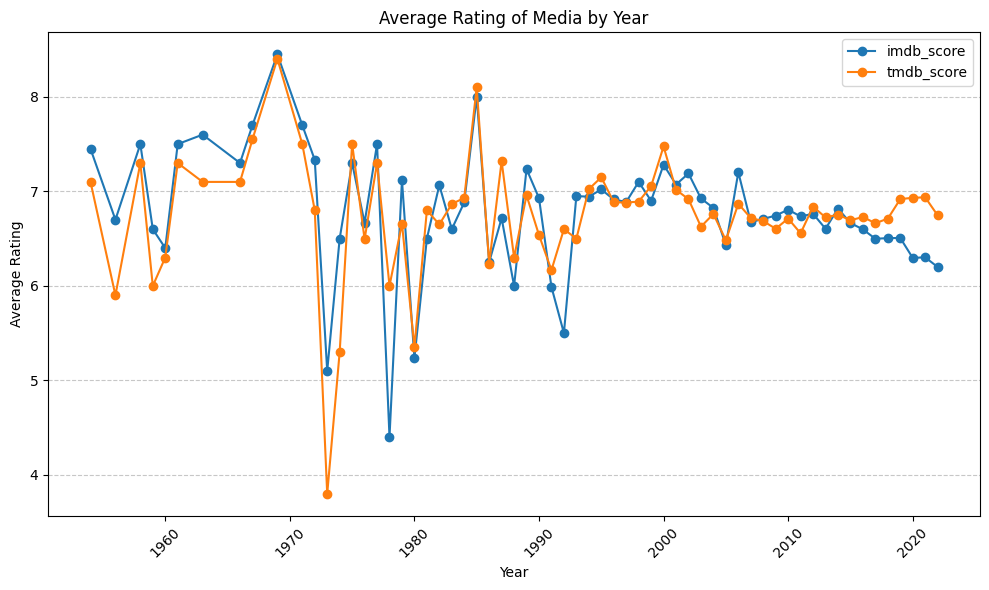

In [55]:
# Rating of movies and shows over time
score_columns = ['imdb_score','tmdb_score']
avg_media_ratings = media_df.groupby('release_year')[score_columns].mean()

def plot_avg_rating_by_year(avg_ratings):
    plt.figure(figsize=(10, 6))
    
    for column in score_columns:
        plt.plot(avg_ratings.index, avg_ratings[column], marker='o', linestyle='-', label=column)
    
    # Plot line graphs
    plt.title('Average Rating of Media by Year')
    plt.xlabel('Year')
    plt.ylabel('Average Rating')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_avg_rating_by_year(avg_media_ratings)

## Line graph showing correlation of imdb_score vs imdb_votes

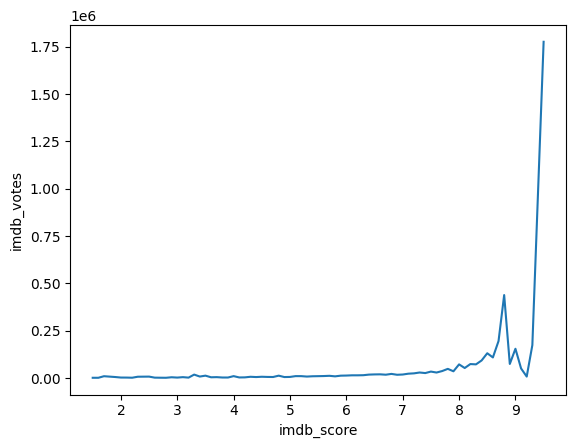

In [56]:
g = sns.lineplot(x="imdb_score", y="imdb_votes", data=media_df, errorbar=None)

## Scatter plot showing correlation of imdb_score vs imdb_votes

Text(0, 0.5, 'imdb_votes')

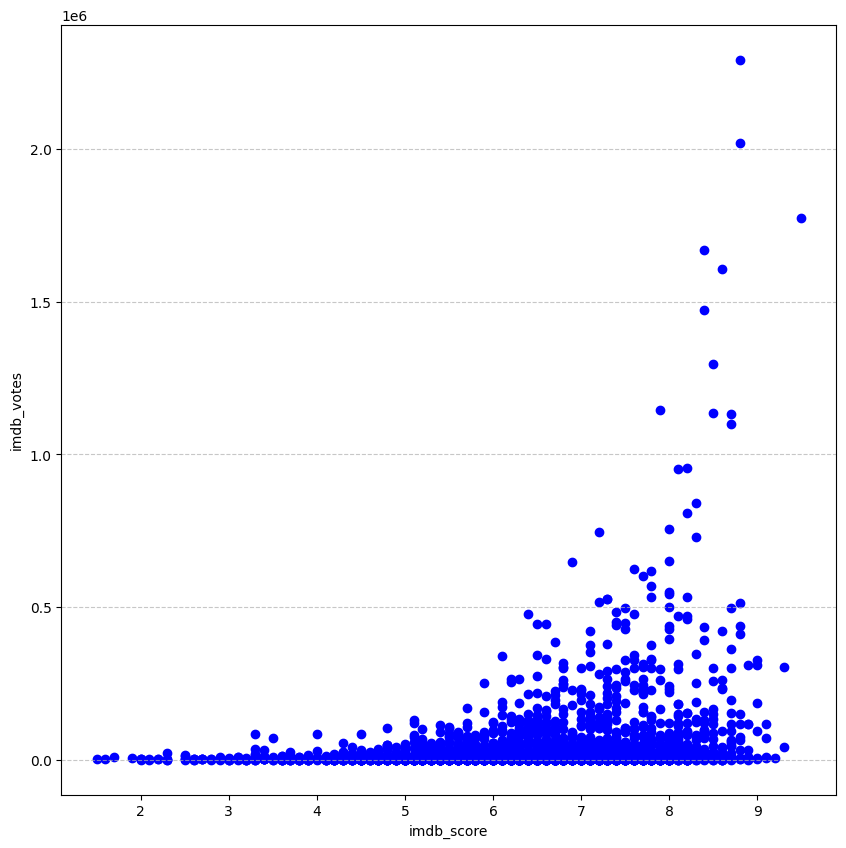

In [57]:
X = media_df["imdb_score"]
y = media_df["imdb_votes"]

fig, pl = plt.subplots(figsize=(10, 10))
pl.scatter(X, y, color = 'b')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlabel("imdb_score")
plt.ylabel("imdb_votes")

## Correlation between imdb_score and filmmakers average cumulative media imdb scores

### Here we add two new columns that refer to the cumulative average imdb scores of the actors and directors for each piece of media

In [58]:
# Merge titles dataframe with credits dataframe
combined_df = pd.merge(titles_df, credits_df, left_on = "id", right_on = "id")

actor_df=combined_df[combined_df['role']=='ACTOR']
director_df=combined_df[combined_df['role']=='DIRECTOR']

# Calculate average scores for actors and directors
actors_avg_scores = actor_df.groupby('person_id')['imdb_score'].mean().reset_index()
directors_avg_scores = director_df.groupby('person_id')['imdb_score'].mean().reset_index()

# Function to calculate cumulative average score
def calculate_cumulative_avg(person_ids, avg_scores_df):
    scores = avg_scores_df[avg_scores_df['person_id'].isin(person_ids)]['imdb_score']

    if len(scores) == 0:
        return None
    return scores.mean()

# Apply the function to each row in 'media_df' and create new columns
media_df['cumulative_avg_actor_score'] = media_df['actor_ids'].apply(lambda x: calculate_cumulative_avg(x, actors_avg_scores))
media_df['cumulative_avg_director_score'] = media_df['director_ids'].apply(lambda x: calculate_cumulative_avg(x, directors_avg_scores))

media_df

id                            title   type  \
0       tm84618                      Taxi Driver  MOVIE   
1      tm154986                      Deliverance  MOVIE   
2      tm127384  Monty Python and the Holy Grail  MOVIE   
3      tm120801                  The Dirty Dozen  MOVIE   
4       ts22164     Monty Python's Flying Circus   SHOW   
...         ...                              ...    ...   
5484  tm1216735                  Sun of the Soil  MOVIE   
5485   tm985215             Princess 'Daya'Reese  MOVIE   
5486  tm1097142                         My Bride  MOVIE   
5487  tm1014599                        Fine Wine  MOVIE   
5488  tm1059008                          Lokillo  MOVIE   

                                            description  release_year  \
0     A mentally unstable Vietnam War veteran works ...          1976   
1     Intent on seeing the Cahulawassee River before...          1972   
2     King Arthur, accompanied by his squire, recrui...          1975   
3     12 American military prisoners in World War II...          1967   
4     A British sketch comedy series with the shows ...          1969   
...                                                 ...           ...   
5484  In 14th-century Mali, an ambitious young royal...          2022   
5485  Reese is a con artist from Manila who dreams o...          2021   
5486  The story follows a young man and woman who go...          2021   
5487  A beautiful love story that can happen between...          2021   
5488  A controversial TV host and comedian who has b...          2021   

     age_certification  runtime                                       genres  \
0                    R      114                           ['drama', 'crime']   
1                    R      109  ['drama', 'action', 'thriller', 'european']   
2                   PG       91              ['fantasy', 'action', 'comedy']   
3                  NaN      150                            ['war', 'action']   
4                TV-14       30                       ['comedy', 'european']   
...                ...      ...                                          ...   
5484               NaN       26                                           []   
5485               NaN      115                        ['comedy', 'romance']   
5486               NaN       93               ['romance', 'comedy', 'drama']   
5487               NaN      100                         ['romance', 'drama']   
5488               NaN       90                                   ['comedy']   

     production_countries  seasons  ... imdb_votes  tmdb_popularity  \
0                  ['US']      NaN  ...   808582.0           40.965   
1                  ['US']      NaN  ...   107673.0           10.010   
2                  ['GB']      NaN  ...   534486.0           15.461   
3            ['GB', 'US']      NaN  ...    72662.0           20.398   
4                  ['GB']      4.0  ...    73424.0           17.617   
...                   ...      ...  ...        ...              ...   
5484                   []      NaN  ...        NaN            1.179   
5485               ['PH']      NaN  ...       50.0            1.383   
5486               ['EG']      NaN  ...      327.0            2.545   
5487               ['NG']      NaN  ...       45.0            1.466   
5488               ['CO']      NaN  ...       68.0           26.005   

      tmdb_score                                          character  \
0          8.179  [Travis Bickle, Iris Steensma, Tom, Matthew 'S...   
1          7.300  [Ed Gentry, Lewis Medlock, Bobby Trippe, Drew ...   
2          7.811  [King Arthur / Voice of God / Middle Head / Hi...   
3          7.600  [Maj. John Reisman, Maj. Gen. Worden, Joseph W...   
4          8.306  [Various, Various / "It's" man, Various, Vario...   
...          ...                                                ...   
5484       7.000                                              [nan]   
5485         NaN  [nan, nan, nan, nan, nan, n

release_year   runtime   seasons  imdb_score  \
release_year                       1.000000 -0.177101 -0.535886   -0.130013   
runtime                           -0.177101  1.000000 -0.151898   -0.147415   
seasons                           -0.535886 -0.151898  1.000000    0.104950   
imdb_score                        -0.130013 -0.147415  0.104950    1.000000   
imdb_votes                        -0.208240  0.134900  0.204067    0.197259   
tmdb_popularity                    0.046217 -0.007768  0.166052    0.018180   
tmdb_score                         0.029133 -0.271951  0.048226    0.587753   
cumulative_avg_actor_score        -0.133388 -0.123253  0.063692    0.940292   
cumulative_avg_director_score     -0.115726 -0.056355 -0.040094    0.933886   

                               imdb_votes  tmdb_popularity  tmdb_score  \
release_year                    -0.208240         0.046217    0.029133   
runtime                          0.134900        -0.007768   -0.271951   
seasons                          0.204067         0.166052    0.048226   
imdb_score                       0.197259         0.018180    0.587753   
imdb_votes                       1.000000         0.207808    0.121751   
tmdb_popularity                  0.207808         1.000000    0.079296   
tmdb_score                       0.121751         0.079296    1.000000   
cumulative_avg_actor_score       0.180997         0.008737    0.529032   
cumulative_avg_director_score    0.166000        -0.037726    0.581226   

                               cumulative_avg_actor_score  \
release_year                                    -0.133388   
runtime                                         -0.123253   
seasons                                          0.063692   
imdb_score                                       0.940292   
imdb_votes                                       0.180997   
tmdb_popularity                                  0.008737   
tmdb_score                                       0.529032   
cumulative_avg_actor_score                       1.000000   
cumulative_avg_director_score                    0.904946   

                               cumulative_avg_director_score  
release_year                                       -0.115726  
runtime                                            -0.056355  
seasons                                            -0.040094  
imdb_score                                          0.933886  
imdb_votes                                          0.166000  
tmdb_popularity                                    -0.037726  
tmdb_score                                          0.581226  
cumulative_avg_actor_score                          0.904946  
cumulative_avg_director_score                       1.000000

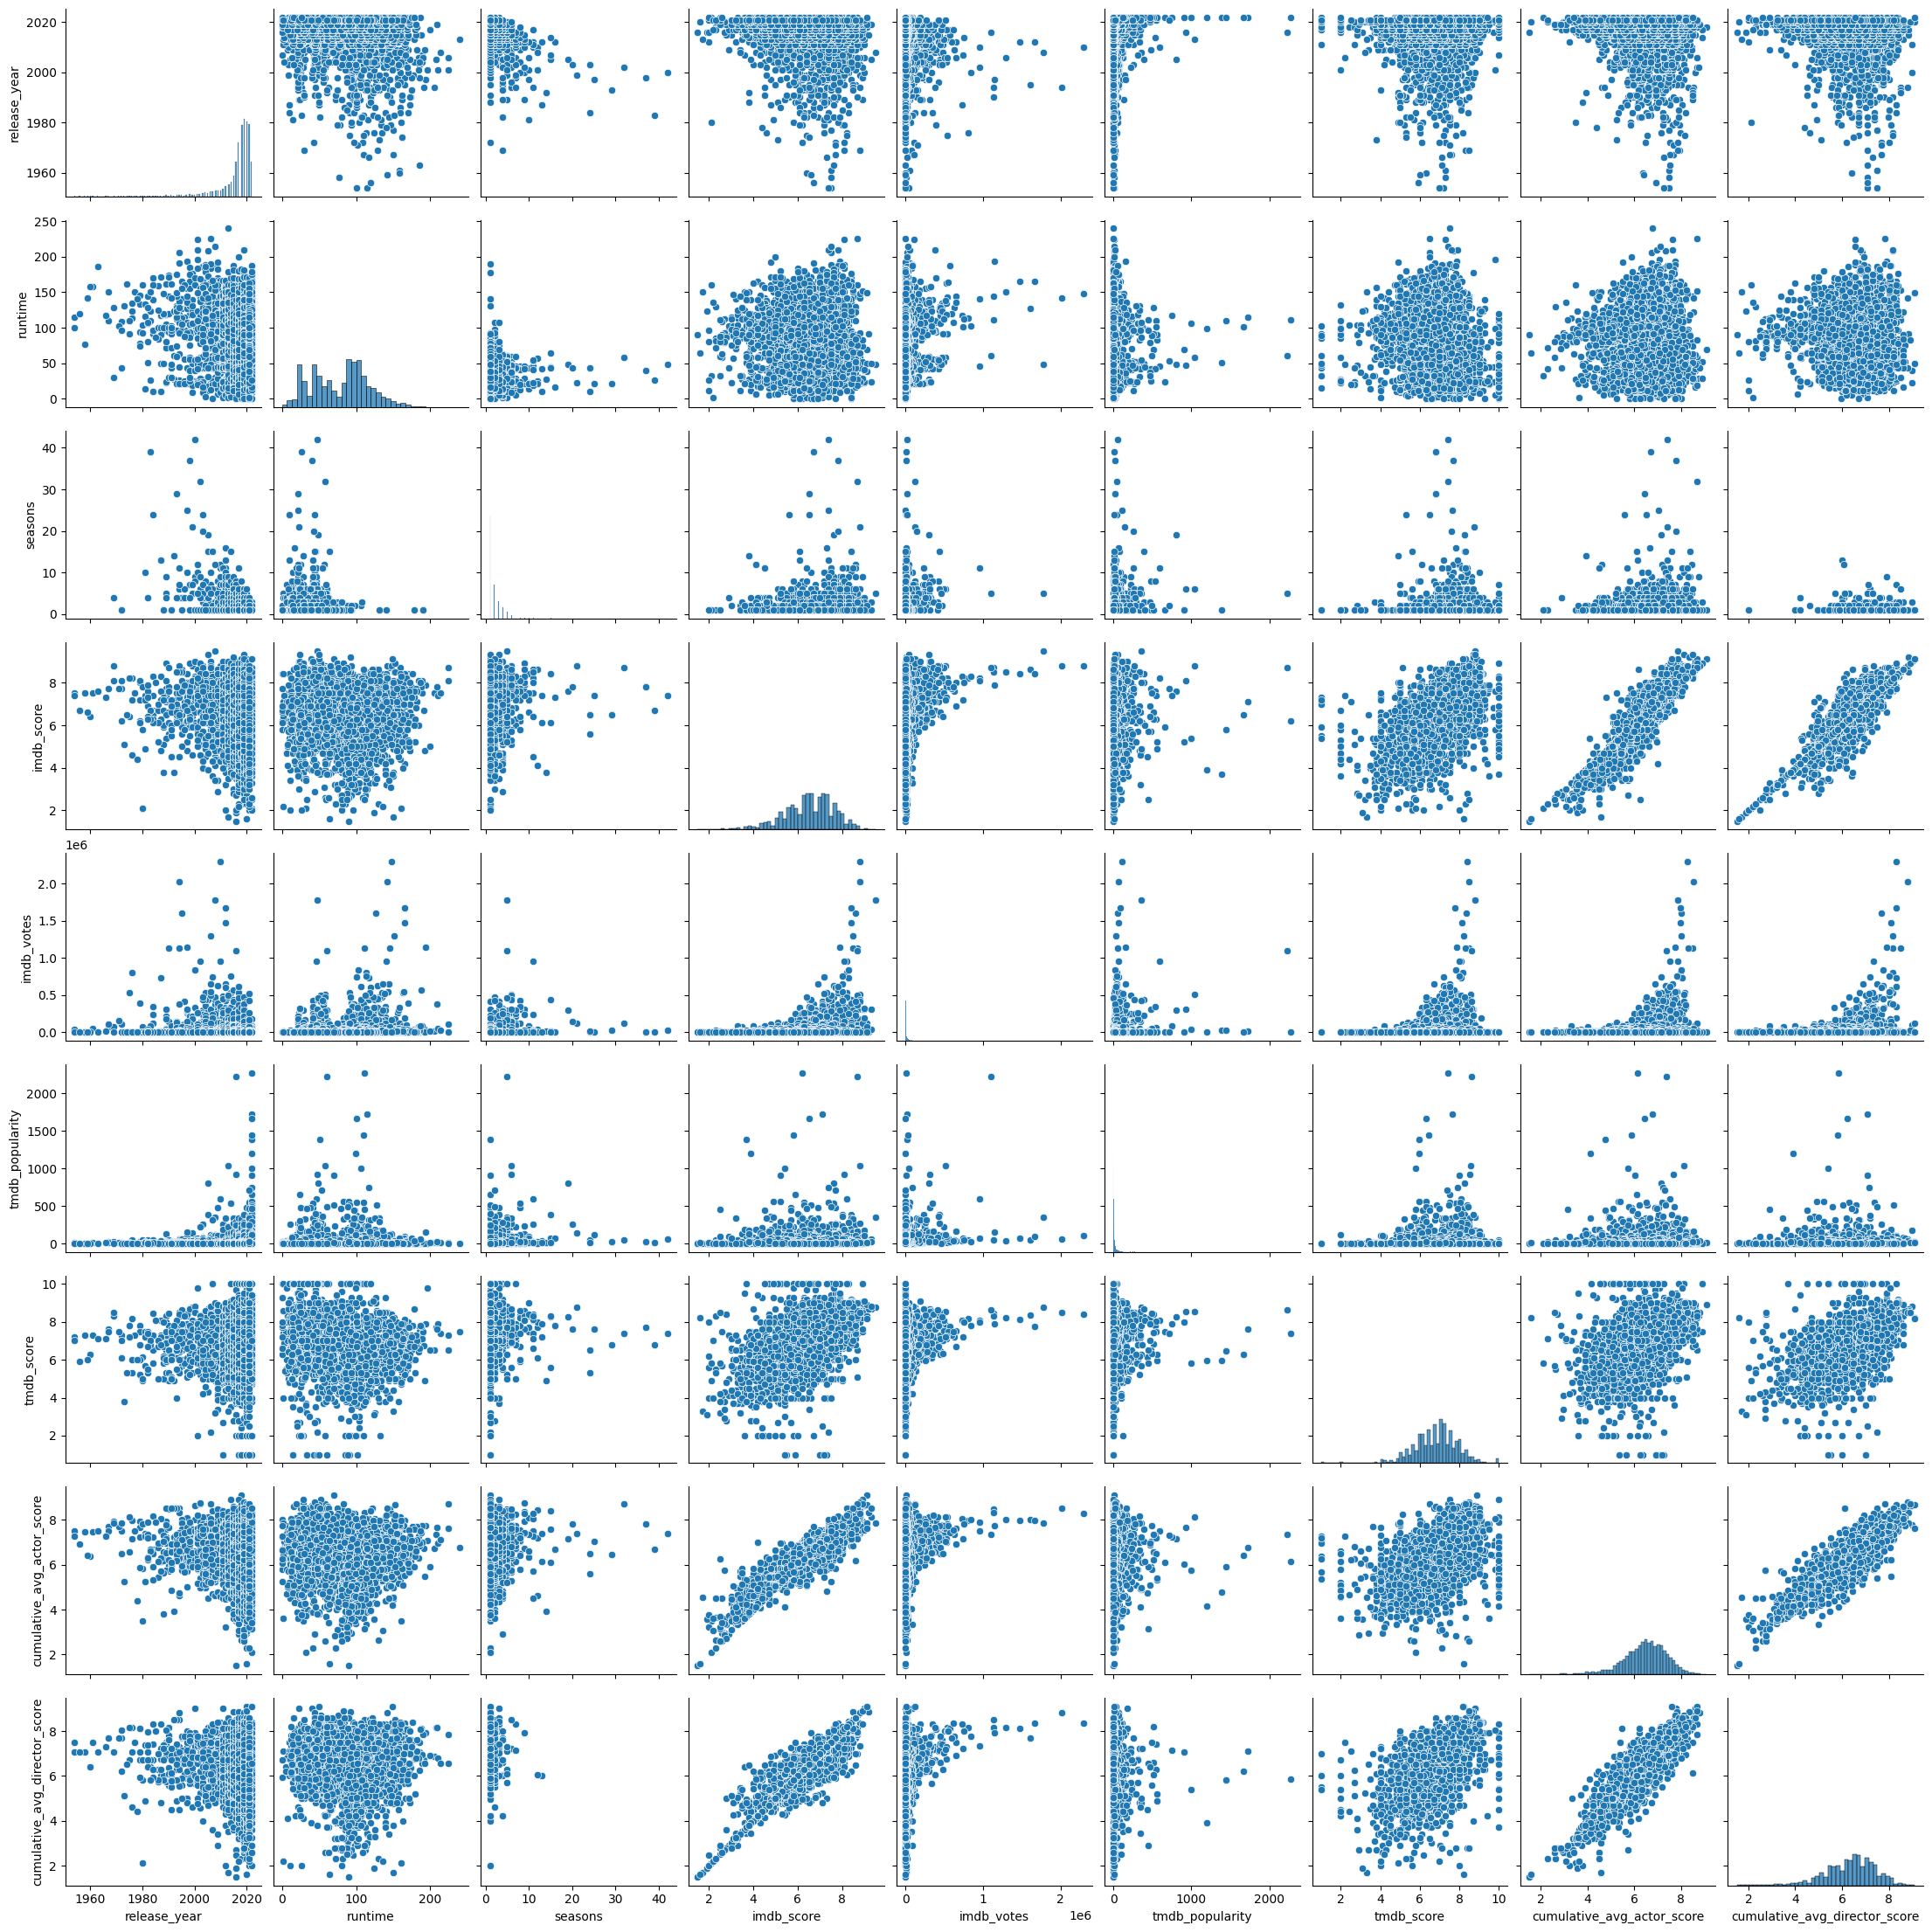

In [59]:
sns.pairplot(media_df)
corr_matrix_new = media_df.corr(numeric_only=True)
corr_matrix_new

## Hot encoded Genres

In [60]:
# Initialize an empty list to store all genres
genres_list = []

# Use ast.literal_eval to store all genres into a list
for x in media_df['genres']:
    genres_list.extend(ast.literal_eval(x))

# Remove duplicates
genres_set = list(set(genres_list))

# Create a DataFrame of genres with binary values (0 or 1)
genres_df = media_df['genres'].apply(lambda x: pd.Series([1 if genre in ast.literal_eval(x) else 0 for genre in genres_set], index=genres_set))

# Concatenate the new DataFrame with the original one
media_df = pd.concat([media_df, genres_df], axis=1)

# Drop NaN values in 'imdb_score' column
# media_df = media_df.dropna(subset=['imdb_score'])

# Drop the 'genres' column
media_df = media_df.drop('genres', axis=1)

# Drop duplicates based on the 'id' column
# media_df = media_df.drop_duplicates(subset='id')
# media_df.reset_index(drop=True, inplace=True)

media_df

id                            title   type  \
0       tm84618                      Taxi Driver  MOVIE   
1      tm154986                      Deliverance  MOVIE   
2      tm127384  Monty Python and the Holy Grail  MOVIE   
3      tm120801                  The Dirty Dozen  MOVIE   
4       ts22164     Monty Python's Flying Circus   SHOW   
...         ...                              ...    ...   
5484  tm1216735                  Sun of the Soil  MOVIE   
5485   tm985215             Princess 'Daya'Reese  MOVIE   
5486  tm1097142                         My Bride  MOVIE   
5487  tm1014599                        Fine Wine  MOVIE   
5488  tm1059008                          Lokillo  MOVIE   

                                            description  release_year  \
0     A mentally unstable Vietnam War veteran works ...          1976   
1     Intent on seeing the Cahulawassee River before...          1972   
2     King Arthur, accompanied by his squire, recrui...          1975   
3     12 American military prisoners in World War II...          1967   
4     A British sketch comedy series with the shows ...          1969   
...                                                 ...           ...   
5484  In 14th-century Mali, an ambitious young royal...          2022   
5485  Reese is a con artist from Manila who dreams o...          2021   
5486  The story follows a young man and woman who go...          2021   
5487  A beautiful love story that can happen between...          2021   
5488  A controversial TV host and comedian who has b...          2021   

     age_certification  runtime production_countries  seasons     imdb_id  \
0                    R      114               ['US']      NaN   tt0075314   
1                    R      109               ['US']      NaN   tt0068473   
2                   PG       91               ['GB']      NaN   tt0071853   
3                  NaN      150         ['GB', 'US']      NaN   tt0061578   
4                TV-14       30               ['GB']      4.0   tt0063929   
...                ...      ...                  ...      ...         ...   
5484               NaN       26                   []      NaN         NaN   
5485               NaN      115               ['PH']      NaN  tt13399802   
5486               NaN       93               ['EG']      NaN  tt14216488   
5487               NaN      100               ['NG']      NaN  tt13857480   
5488               NaN       90               ['CO']      NaN  tt14585902   

      ...  western  reality  thriller  animation comedy action horror war  \
0     ...        0        0         0          0      0      0      0   0   
1     ...        0        0         1          0      0      1      0   0   
2     ...        0        0         0          0      1      1      0   0   
3     ...        0        0         0          0      0      1      0   1   
4     ...        0        0         0          0      1      0      0   0   
...   ...      ...      ...       ...        ...    ...    ...    ...  ..   
5484  ...        0        0         0          0      0      0      0   0   
5485  ...        0        0         0          0      1      0      0   0   
5486  ...        0        0         0          0      1      0      0   0   
5487  ...        0        0         0          0      0      0      0   0   
5488  ...        0        0         0          0      1      0      0   0   

     family  crime  
0         0      1  
1         0      0  
2         0      0  
3         0      0  
4         0      0  
...     ...    ...  
5484      0      0  
5485      0      0  
5486      0      0  
5487      0      0  
5488      0      0  

[5489 rows x 40 columns]

release_year   runtime   seasons  imdb_score  \
release_year                       1.000000 -0.212512  0.017411   -0.147428   
runtime                           -0.212512  1.000000 -0.461356   -0.039139   
seasons                            0.017411 -0.461356  1.000000    0.193170   
imdb_score                        -0.147428 -0.039139  0.193170    1.000000   
imdb_votes                        -0.226475  0.189119 -0.053499    0.183442   
cumulative_avg_actor_score        -0.151886 -0.029005  0.203186    0.946671   
cumulative_avg_director_score     -0.123782 -0.047316  0.201822    0.932269   
history                            0.007236  0.067175  0.013934    0.125641   
music                              0.044841 -0.015950 -0.014418    0.019687   
documentation                      0.046490 -0.173192 -0.005239    0.221316   
european                          -0.053989  0.050044 -0.029319   -0.010076   
scifi                              0.020715 -0.068182  0.102854   -0.044129   
romance                           -0.030264  0.144153  0.043099   -0.032883   
sport                              0.017037  0.013497  0.010414    0.032378   
fantasy                            0.005494 -0.062051  0.071525   -0.014648   
drama                             -0.058221  0.263377  0.023651    0.104155   
western                           -0.030650  0.042664 -0.024105   -0.012322   
reality                            0.030585 -0.097158  0.169339    0.026351   
thriller                          -0.004717  0.163221 -0.013532   -0.098805   
animation                         -0.017670 -0.197707  0.162943    0.018755   
comedy                             0.017346 -0.148274 -0.000362   -0.095131   
action                            -0.132467  0.185580  0.015681   -0.068453   
horror                             0.035313  0.002166 -0.027805   -0.160769   
war                               -0.105652  0.070256 -0.003359    0.089558   
family                             0.022637 -0.099053  0.031739   -0.077285   
crime                             -0.062370  0.116384  0.041641    0.031575   
cumulative_imdb                    0.002557 -0.037080  0.037758    0.326130   

                               imdb_votes  cumulative_avg_actor_score  \
release_year                    -0.226475                   -0.151886   
runtime                          0.189119                   -0.029005   
seasons                         -0.053499                    0.203186   
imdb_score                       0.183442                    0.946671   
imdb_votes                       1.000000                    0.182500   
cumulative_avg_actor_score       0.182500                    1.000000   
cumulative_avg_director_score    0.171041                    0.910716   
history                          0.021795                    0.132558   
music                           -0.011106                    0.021394   
documentation                   -0.075199                    0.232335   
european                         0.033910                   -0.012060   
scifi                            0.072130                   -0.028501   
romance                         -0.030196                   -0.024364   
sport                           -0.009580                    0.041370   
fantasy                          0.022459                    0.004032   
drama                            0.051723                    0.119261   
western                          0.079190                   -0.017551   
reality                         -0.014460                    0.027358   
thriller                         0.134471                   -0.087200   
animation                       -0.025609                    0.045345   
comedy                          -0.077891                   -0.133237   
action                           0.106769                   -0.038841   
horror                           0.029482                   -0.148841   
war                              0.052054                    0.091

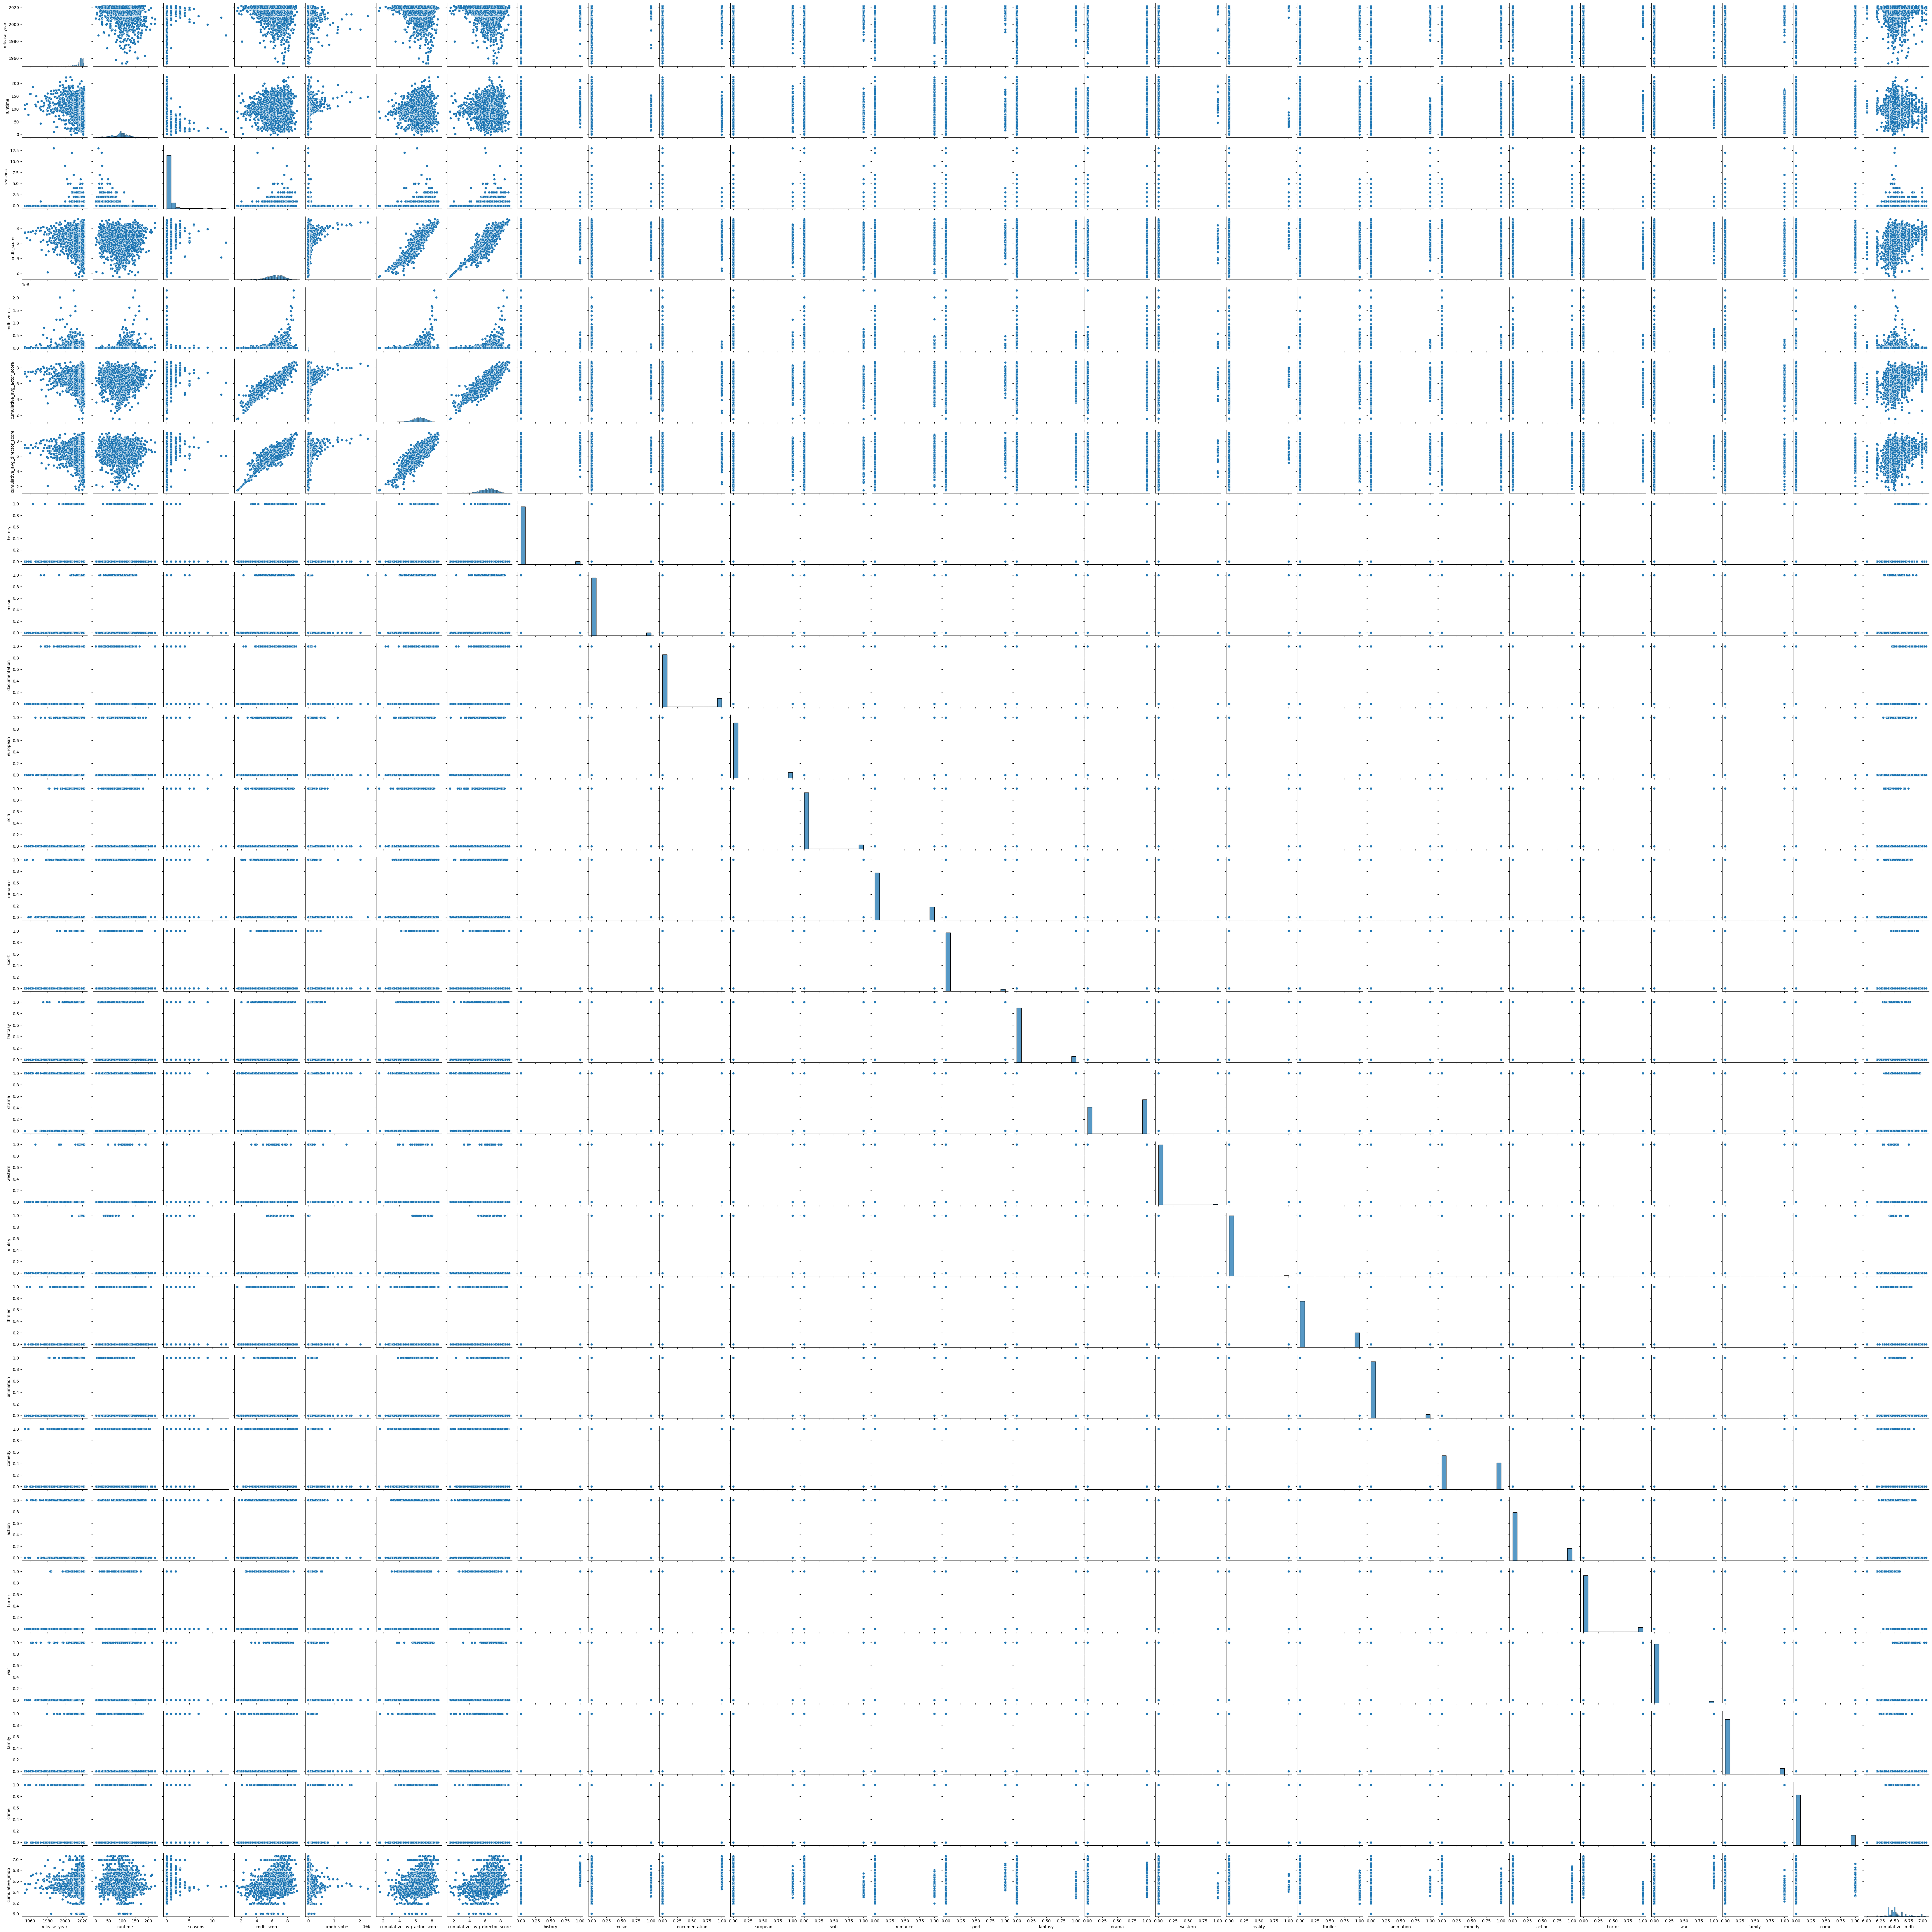

In [81]:
sns.pairplot(media_df)
corr_matrix_new = media_df.corr(numeric_only=True)
corr_matrix_new

/tmp/ipykernel_362/3263471011.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=average_scores_df['Genre'], y=average_scores_df['Average IMDb Score'], palette='viridis')


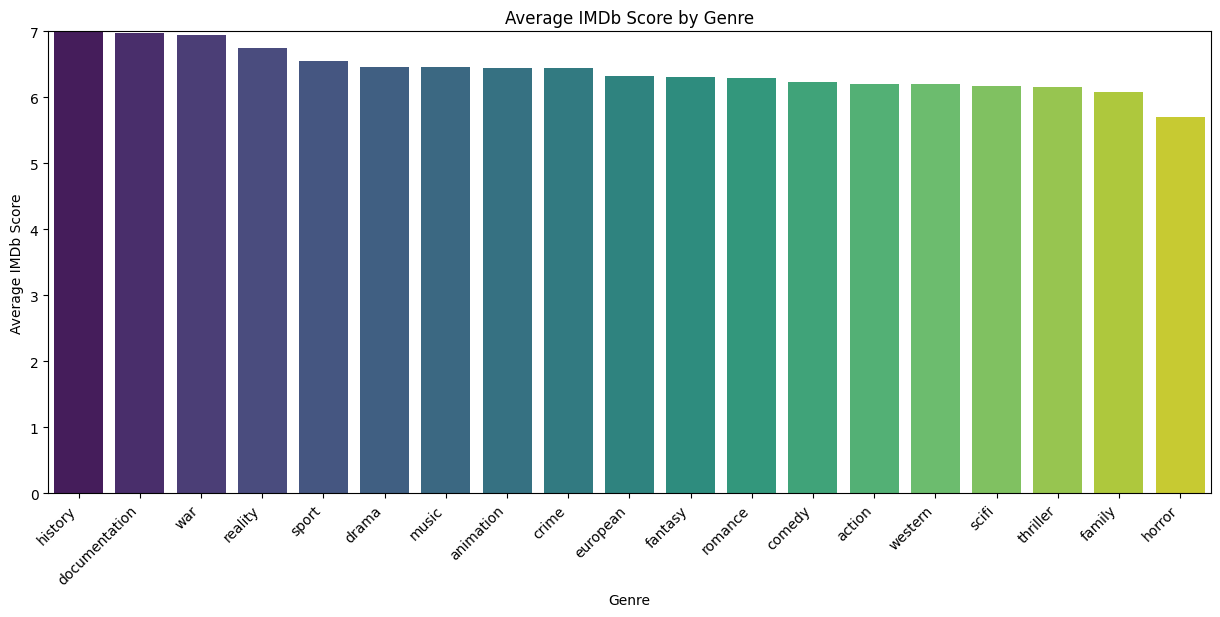

/tmp/ipykernel_362/3263471011.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')


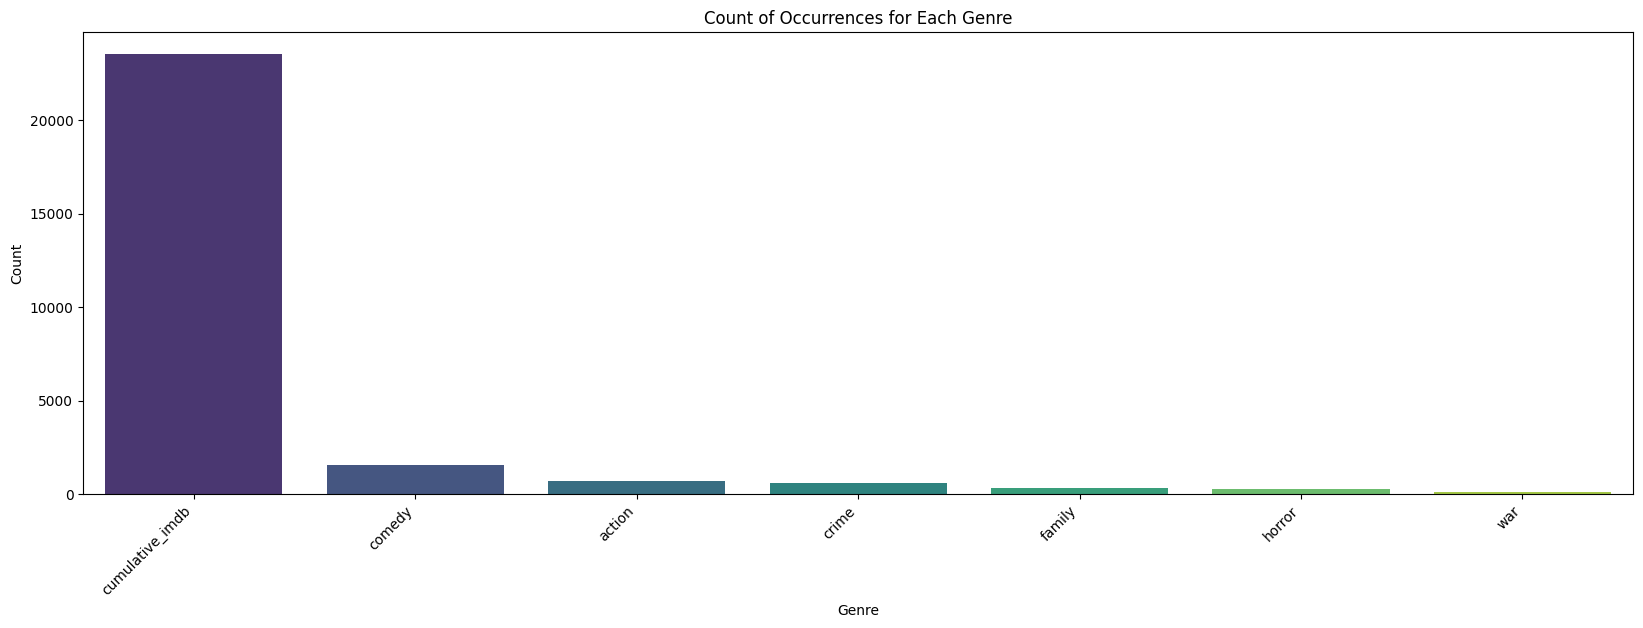

In [80]:
# Calculate the average IMDb score for each genre
average_scores_by_genre = {}
for genre in genres_set:
    genre_columns = [col for col in media_df.columns if genre in col]
    average_scores_by_genre[genre] = media_df[media_df[genre_columns].any(axis=1)]['imdb_score'].mean()

# Convert the result into a DataFrame
average_scores_df = pd.DataFrame(list(average_scores_by_genre.items()), columns=['Genre', 'Average IMDb Score'])

# Sort genres by average score in descending order
average_scores_df = average_scores_df.sort_values(by='Average IMDb Score', ascending=False)


# Plotting Average Scores
# plt.figure(figsize=(15, 6))
# sns.barplot(x=average_scores_df['Genre'], y=average_scores_df['Average IMDb Score'], palette='viridis')
# plt.title('Average IMDb Score by Genre')
# plt.xlabel('Genre')
# plt.ylabel('Average IMDb Score')
# plt.ylim(0,7)
# plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
# plt.show()

# genre_counts = media_df.iloc[:, 20:].sum()
# genre_counts = genre_counts.sort_values(ascending=False)

# # Plotting the count of occurrences for each genre
# plt.figure(figsize=(20, 6))
# sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')
# plt.title('Count of Occurrences for Each Genre')
# plt.xlabel('Genre')
# plt.ylabel('Count')
# plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
# plt.show()

In [62]:
media_df['cumulative_imdb'] = 0

# Lowercase the genre names in media_df columns
media_df.columns = [col.lower() for col in media_df.columns]

for index, row in media_df.iterrows():
    score = 0
    numCount = 0

    for genre in media_df.columns[20:]:
        if row[genre] == 1:
            numCount += 1
            genre_name = genre.split('_')[-1].lower()  # Extract genre name and lowercase
            if genre_name in average_scores_df['Genre'].str.lower().values:
                score += average_scores_df.loc[average_scores_df['Genre'].str.lower() == genre_name, 'Average IMDb Score'].values[0]
    
    if numCount > 0:
        score /= numCount

    media_df.at[index, 'cumulative_imdb'] = score

media_df

/tmp/ipykernel_362/1430677997.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '6.635201686699313' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  media_df.at[index, 'cumulative_imdb'] = score


id                            title   type  \
0       tm84618                      Taxi Driver  MOVIE   
1      tm154986                      Deliverance  MOVIE   
2      tm127384  Monty Python and the Holy Grail  MOVIE   
3      tm120801                  The Dirty Dozen  MOVIE   
4       ts22164     Monty Python's Flying Circus   SHOW   
...         ...                              ...    ...   
5484  tm1216735                  Sun of the Soil  MOVIE   
5485   tm985215             Princess 'Daya'Reese  MOVIE   
5486  tm1097142                         My Bride  MOVIE   
5487  tm1014599                        Fine Wine  MOVIE   
5488  tm1059008                          Lokillo  MOVIE   

                                            description  release_year  \
0     A mentally unstable Vietnam War veteran works ...          1976   
1     Intent on seeing the Cahulawassee River before...          1972   
2     King Arthur, accompanied by his squire, recrui...          1975   
3     12 American military prisoners in World War II...          1967   
4     A British sketch comedy series with the shows ...          1969   
...                                                 ...           ...   
5484  In 14th-century Mali, an ambitious young royal...          2022   
5485  Reese is a con artist from Manila who dreams o...          2021   
5486  The story follows a young man and woman who go...          2021   
5487  A beautiful love story that can happen between...          2021   
5488  A controversial TV host and comedian who has b...          2021   

     age_certification  runtime production_countries  seasons     imdb_id  \
0                    R      114               ['US']      NaN   tt0075314   
1                    R      109               ['US']      NaN   tt0068473   
2                   PG       91               ['GB']      NaN   tt0071853   
3                  NaN      150         ['GB', 'US']      NaN   tt0061578   
4                TV-14       30               ['GB']      4.0   tt0063929   
...                ...      ...                  ...      ...         ...   
5484               NaN       26                   []      NaN         NaN   
5485               NaN      115               ['PH']      NaN  tt13399802   
5486               NaN       93               ['EG']      NaN  tt14216488   
5487               NaN      100               ['NG']      NaN  tt13857480   
5488               NaN       90               ['CO']      NaN  tt14585902   

      ...  reality  thriller  animation  comedy action horror war family  \
0     ...        0         0          0       0      0      0   0      0   
1     ...        0         1          0       0      1      0   0      0   
2     ...        0         0          0       1      1      0   0      0   
3     ...        0         0          0       0      1      0   1      0   
4     ...        0         0          0       1      0      0   0      0   
...   ...      ...       ...        ...     ...    ...    ...  ..    ...   
5484  ...        0         0          0       0      0      0   0      0   
5485  ...        0         0          0       1      0      0   0      0   
5486  ...        0         0          0       1      0      0   0      0   
5487  ...        0         0          0       0      0      0   0      0   
5488  ...        0         0          0       1      0      0   0      0   

     crime  cumulative_imdb  
0        1         6.635202  
1        0         6.480488  
2        0         6.455812  
3        0         6.741455  
4        0         6.447009  
...    ...              ...  
5484     0         0.000000  
5485     0         6.384078  
5486     0         6.464579  
5487     0         6.503723  
5488     0         6.386289  

[5489 rows x 41 columns]

# Data Cleaning

Remove all unnecessary data based on correlations gathered from previous observations and prepare the data for preprocessing.

In [63]:
# Data cleaning
media_df = media_df.drop(columns=['imdb_id','tmdb_popularity','tmdb_score','character'], axis=1)
media_df.dropna(subset=['title','imdb_score','imdb_votes'], inplace=True)
media_df['seasons']=media_df['seasons'].fillna(0)

media_df.reset_index()

index         id                            title   type  \
0         0    tm84618                      Taxi Driver  MOVIE   
1         1   tm154986                      Deliverance  MOVIE   
2         2   tm127384  Monty Python and the Holy Grail  MOVIE   
3         3   tm120801                  The Dirty Dozen  MOVIE   
4         4    ts22164     Monty Python's Flying Circus   SHOW   
...     ...        ...                              ...    ...   
5044   5483  tm1165179                      Kongsi Raya  MOVIE   
5045   5485   tm985215             Princess 'Daya'Reese  MOVIE   
5046   5486  tm1097142                         My Bride  MOVIE   
5047   5487  tm1014599                        Fine Wine  MOVIE   
5048   5488  tm1059008                          Lokillo  MOVIE   

                                            description  release_year  \
0     A mentally unstable Vietnam War veteran works ...          1976   
1     Intent on seeing the Cahulawassee River before...          1972   
2     King Arthur, accompanied by his squire, recrui...          1975   
3     12 American military prisoners in World War II...          1967   
4     A British sketch comedy series with the shows ...          1969   
...                                                 ...           ...   
5044  Jack - a Chinese chef-manager who is in-line t...          2022   
5045  Reese is a con artist from Manila who dreams o...          2021   
5046  The story follows a young man and woman who go...          2021   
5047  A beautiful love story that can happen between...          2021   
5048  A controversial TV host and comedian who has b...          2021   

     age_certification  runtime production_countries  seasons  ...  reality  \
0                    R      114               ['US']      0.0  ...        0   
1                    R      109               ['US']      0.0  ...        0   
2                   PG       91               ['GB']      0.0  ...        0   
3                  NaN      150         ['GB', 'US']      0.0  ...        0   
4                TV-14       30               ['GB']      4.0  ...        0   
...                ...      ...                  ...      ...  ...      ...   
5044               NaN      102               ['MY']      0.0  ...        0   
5045               NaN      115               ['PH']      0.0  ...        0   
5046               NaN       93               ['EG']      0.0  ...        0   
5047               NaN      100               ['NG']      0.0  ...        0   
5048               NaN       90               ['CO']      0.0  ...        0   

      thriller animation comedy action horror  war  family  crime  \
0            0         0      0      0      0    0       0      1   
1            1         0      0      1      0    0       0      0   
2            0         0      1      1      0    0       0      0   
3            0         0      0      1      0    1       0      0   
4            0         0      1      0      0    0       0      0   
...        ...       ...    ...    ...    ...  ...     ...    ...   
5044         0         0      1      0      0    0       0      0   
5045         0         0      1      0      0    0       0      0   
5046         0         0      1      0      0    0       0      0   
5047         0         0      0      0      0    0       0      0   
5048         0         0      1      0      0    0       0      0   

      cumulative_imdb  
0            6.635202  
1            6.480488  
2            6.455812  
3            6.741455  
4            6.447009  
...               ...  
5044         6.386289  
5045         6.384078  
5046         6.464579  
5047         6.503723  
5048         6.386289  

[5049 rows x 38 columns]

In [64]:
media_df=media_df.drop(columns='actor')
media_df=media_df.drop(columns='actor_ids')
media_df=media_df.drop(columns='director')
media_df=media_df.drop(columns='director_ids')
media_df=media_df.drop(columns='production_countries')
media_df=media_df.drop(columns='description')
media_df=media_df.drop(columns='title')
media_df=media_df.drop(columns='age_certification')
media_df=media_df.drop(columns='type')
media_df=media_df.drop(columns='id')
media_df

release_year  runtime  seasons  imdb_score  imdb_votes  \
0             1976      114      0.0         8.2    808582.0   
1             1972      109      0.0         7.7    107673.0   
2             1975       91      0.0         8.2    534486.0   
3             1967      150      0.0         7.7     72662.0   
4             1969       30      4.0         8.8     73424.0   
...            ...      ...      ...         ...         ...   
5483          2022      102      0.0         7.0        66.0   
5485          2021      115      0.0         7.1        50.0   
5486          2021       93      0.0         5.0       327.0   
5487          2021      100      0.0         6.8        45.0   
5488          2021       90      0.0         3.8        68.0   

      cumulative_avg_actor_score  cumulative_avg_director_score  history  \
0                       7.983333                           8.16        0   
1                       7.521970                           7.70        0   
2                       8.142933                           8.15        0   
3                       7.686111                           7.70        0   
4                       7.952042                            NaN        0   
...                          ...                            ...      ...   
5483                    6.645833                           6.55        0   
5485                    6.731270                           4.80        0   
5486                    5.068889                           5.00        0   
5487                    6.035909                           5.05        0   
5488                    3.890000                           3.80        0   

      music  documentation  ...  reality  thriller  animation  comedy  action  \
0         0              0  ...        0         0          0       0       0   
1         0              0  ...        0         1          0       0       1   
2         0              0  ...        0         0          0       1       1   
3         0              0  ...        0         0          0       0       1   
4         0              0  ...        0         0          0       1       0   
...     ...            ...  ...      ...       ...        ...     ...     ...   
5483      0              0  ...        0         0          0       1       0   
5485      0              0  ...        0         0          0       1       0   
5486      0              0  ...        0         0          0       1       0   
5487      0              0  ...        0         0          0       0       0   
5488      0              0  ...        0         0          0       1       0   

      horror  war  family  crime  cumulative_imdb  
0          0    0       0      1         6.635202  
1          0    0       0      0         6.480488  
2          0    0       0      0         6.455812  
3          0    1       0      0         6.741455  
4          0    0       0      0         6.447009  
...      ...  ...     ...    ...              ...  
5483       0    0       0      0         6.386289  
5485       0    0       0      0         6.384078  
5486       0    0       0      0         6.464579  
5487       0    0       0      0         6.503723  
5488       0    0       0      0         6.386289  

[5049 rows x 27 columns]

In [65]:
media_df=media_df.dropna()

In [66]:

#create the cat and num columns
num_cols = media_df.select_dtypes(include='number').columns.to_list()
cat_cols = media_df.select_dtypes(exclude='number').columns.to_list()


#exclude the target from numerical columns
num_cols.remove("imdb_score")

#create pipelines for numeric and categorical columns
num_pipeline = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())
cat_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder())

#use ColumnTransformer to set the estimators and transformations


preprocessing = ColumnTransformer([('num', num_pipeline, num_cols),
                                   ('cat', cat_pipeline, cat_cols)],
                                    remainder='passthrough'
                                 )

In [67]:
preprocessing

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['release_year', 'runtime', 'seasons',
                                  'imdb_votes', 'cumulative_avg_actor_score',
                                  'cumulative_avg_director_score', 'history',
                                  'music', 'documentation', 'european', 'scifi',
                                  'romance', 'sport', 'fantasy', 'drama',
                                  'western', 'reality', 'thriller', 'animation',
                                  'comedy', 'action', 'horror', 'war', 'family',
                                  'crime', 'cumulative_imdb']),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder())]),
                                 [])])

## Split the data into testing and training sets

In [68]:
X = media_df.drop("imdb_score", axis=1)
y = media_df['imdb_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2882, 26) (2882,) (721, 26) (721,)


## Applying the preprocessing

In [69]:
# Apply the preprocessing pipeline on the dataset
mediaPrepared = preprocessing.fit_transform(media_df)

# Scikit-learn strips the column headers in most cases, so just add them back on afterward.
feature_names=preprocessing.get_feature_names_out()
students_prepared = pd.DataFrame(data=mediaPrepared, columns=feature_names)
 
students_prepared

num__release_year  num__runtime  num__seasons  num__imdb_votes  \
0             -5.292002      0.578190     -0.277416         7.518581   
1             -5.822262      0.421241     -0.277416         0.785483   
2             -5.424567     -0.143777     -0.277416         4.885550   
3             -6.485087      1.708226     -0.277416         0.449159   
4             -4.894307     -0.049607     -0.277416         3.545845   
...                 ...           ...           ...              ...   
3598           0.805986      0.201512     -0.277416        -0.248216   
3599           0.673421      0.609580     -0.277416        -0.248370   
3600           0.673421     -0.080997     -0.277416        -0.245709   
3601           0.673421      0.138732     -0.277416        -0.248418   
3602           0.673421     -0.175166     -0.277416        -0.248197   

      num__cumulative_avg_actor_score  num__cumulative_avg_director_score  \
0                            1.760616                            1.700412   
1                            1.254077                            1.266077   
2                            1.935843                            1.690970   
3                            1.434290                            1.266077   
4                            1.710007                            1.643759   
...                               ...                                 ...   
3598                         0.292152                            0.180238   
3599                         0.385954                           -1.472125   
3600                        -1.439201                           -1.283284   
3601                        -0.377494                           -1.236073   
3602                        -2.733523                           -2.416333   

      num__history  num__music  num__documentation  num__european  ...  \
0        -0.220461   -0.225943           -0.403278      -0.315406  ...   
1        -0.220461   -0.225943           -0.403278       3.170512  ...   
2        -0.220461   -0.225943           -0.403278      -0.315406  ...   
3        -0.220461   -0.225943           -0.403278      -0.315406  ...   
4        -0.220461   -0.225943           -0.403278      -0.315406  ...   
...            ...         ...                 ...            ...  ...   
3598     -0.220461   -0.225943           -0.403278      -0.315406  ...   
3599     -0.220461   -0.225943           -0.403278      -0.315406  ...   
3600     -0.220461   -0.225943           -0.403278      -0.315406  ...   
3601     -0.220461   -0.225943           -0.403278      -0.315406  ...   
3602     -0.220461   -0.225943           -0.403278      -0.315406  ...   

      num__thriller  num__animation  num__comedy  num__action  num__horror  \
0         -0.562499       -0.265349    -0.888744    -0.507535    -0.281186   
1          1.777782       -0.265349    -0.888744     1.970308    -0.281186   
2         -0.562499       -0.265349     1.125183     1.970308    -0.281186   
3         -0.562499       -0.265349    -0.888744     1.970308    -0.281186   
4         -0.562499       -0.265349     1.125183    -0.507535    -0.281186   
...             ...             ...          ...          ...          ...   
3598      -0.562499       -0.265349     1.125183    -0.507535    -0.281186   
3599      -0.562499       -0.265349     1.125183    -0.507535    -0.281186   
3600      -0.562499       -0.265349     1.125183    -0.507535    -0.281186   
3601      -0.562499       -0.265349    -0.888744    -0.507535    -0.281186   
3602      -0.562499       -0.265349     1.125183    -0.507535    -0.281186   

      num__war  num__family  num__crime  num__cumulative_imdb  \
0    -0.174947    -0.323845    2.234952              0.637759   
1    -0.174947    -0.323845   -0.447437             -0.314811   
2    -0.174947    -0.323845   -0.447437             -0.466741   
3     5.716021    -0.323845   -0.447437              1.291960   
4    -0.174947    -0.323845   -0.447437             -0.894789   


## AI ALgorithms

In [70]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()

lr_model.fit(X_train,y_train)

LinearRegression()

In [71]:

lr_y_predict = lr_model.predict(X_test)

from sklearn.metrics import mean_squared_error as mse
lr_mse=mse(y_test, lr_y_predict)
lr_mse

0.09814485294632676

In [72]:
from sklearn.model_selection import cross_val_score, KFold

scores = cross_val_score(lr_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

scores

array([-0.09092865, -0.09730952, -0.10568539, -0.10025433, -0.08881088])

In [73]:
mean_score = -scores.mean()  # Take the negative value to get the mean squared error

print(f'Cross-Validation Mean Score: {mean_score}')

Cross-Validation Mean Score: 0.0965977535997359


In [74]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

RidgeRegression = Ridge(alpha=1)
ridge_model = RidgeRegression.fit(X_train, y_train)


LassoRegression = Lasso(alpha=1)
lasso_model = LassoRegression.fit(X_train, y_train)
Ridge_y_predict = ridge_model.predict(X_test)
Lasso_y_predict = lasso_model.predict(X_test)
ridge_mse = mse(y_test, Ridge_y_predict)
lasso_mse=mse(y_test, Lasso_y_predict)

print(f'Ridge Regression MSE: {ridge_mse}')
print(f'Lasso Regression MSE: {lasso_mse}')

Ridge Regression MSE: 0.09814781606144053
Lasso Regression MSE: 1.2808147611969478


In [75]:
print(f'Linear Regression MSE: {lr_mse}')
print(f'Cross-Validation Mean Score: {mean_score}')
print(f'Ridge Regression MSE: {ridge_mse}')
print(f'Lasso Regression MSE: {lasso_mse}')

Linear Regression MSE: 0.09814485294632676
Cross-Validation Mean Score: 0.0965977535997359
Ridge Regression MSE: 0.09814781606144053
Lasso Regression MSE: 1.2808147611969478


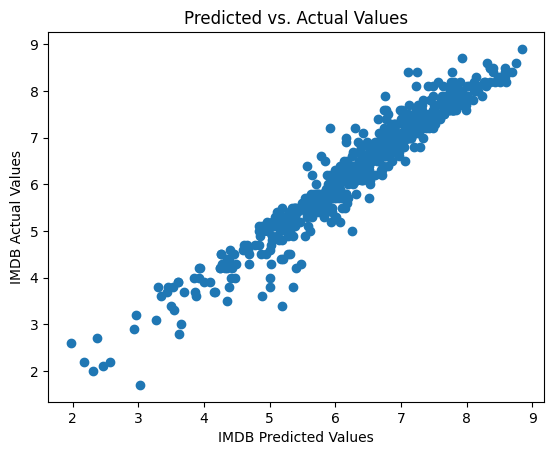

In [76]:
import matplotlib.pyplot as plt

# Assuming 'lr_model' is your best performing trained linear regression model
lr_y_predict = lr_model.predict(X_test)  # X is your feature data
plt.scatter(lr_y_predict, y_test)  # y is your actual target values
plt.xlabel("IMDB Predicted Values")
plt.ylabel("IMDB Actual Values")
plt.title("Predicted vs. Actual Values")
plt.show()

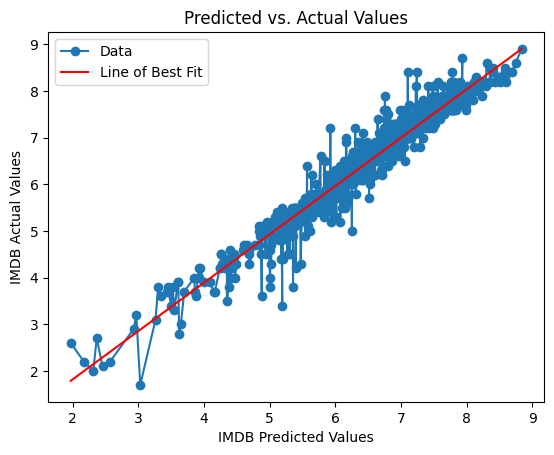

In [77]:
# Sorting predicted values and corresponding actual values
sorted_indices = np.argsort(lr_y_predict)
sorted_lr_y_predict = lr_y_predict[sorted_indices]
sorted_y_test = y_test.values[sorted_indices]  # Assuming y_test is a pandas DataFrame or Series

# Plotting as a line graph
plt.plot(sorted_lr_y_predict, sorted_y_test, marker='o', linestyle='-', label='Data')
plt.xlabel("IMDB Predicted Values")
plt.ylabel("IMDB Actual Values")
plt.title("Predicted vs. Actual Values")

# Adding a line of best fit
lr = LinearRegression()
lr.fit(sorted_lr_y_predict.reshape(-1, 1), sorted_y_test)
plt.plot(sorted_lr_y_predict, lr.predict(sorted_lr_y_predict.reshape(-1, 1)), color='red', label='Line of Best Fit')

plt.legend()
plt.show()

In [78]:
lr_y_predict.mean()

6.365713496147758

In [79]:
median = np.median(lr_y_predict)
median

6.484132238870654